# Initialize the accelerator

In [21]:
from finn_examples import models
print(list(filter(lambda x: "mnist" in x, dir(models))))

['_mnist_fc_io_shape_dict', 'tfc_w1a1_mnist', 'tfc_w1a2_mnist', 'tfc_w2a2_mnist']


In [40]:
accel = models.tfc_w1a1_mnist()
#accel = models.tfc_w2a2_mnist()

In [41]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal()), str(accel.idt())))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal()), str(accel.odt())))

Expected input shape and datatype: (1, 784) UINT8
Expected output shape and datatype: (1, 1) UINT8


# Load the MNIST dataset

Use the `dataset_loading` package to get easy Python access to MNIST dataset:

In [42]:
from dataset_loading import mnist
trainx, trainy, testx, testy, valx, valy = mnist.load_mnist_data("/tmp", download=True, one_hot=False)

Looking for Train Imgs
Tar File found in data_dir. Not Downloading again
Looking for Train Labels
Tar File found in data_dir. Not Downloading again
Looking for Test Imgs
Tar File found in data_dir. Not Downloading again
Looking for Test Labels
Tar File found in data_dir. Not Downloading again


In [43]:
testx.shape

(10000, 28, 28, 1)

# Classify a single image

In [44]:
test_single_x = testx[0].reshape(28, 28)
test_single_y = testy[0]

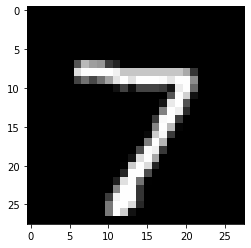

In [45]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.imshow(test_single_x, cmap='gray')
plt.show()

In [46]:
print("Expected class is %d" % test_single_y)

Expected class is 7


In [47]:
accel_in = test_single_x.reshape(accel.ishape_normal())
print("Input buffer shape is %s and datatype is %s" % (str(accel_in.shape), str(accel_in.dtype)))

Input buffer shape is (1, 784) and datatype is uint8


In [48]:
accel_out = accel.execute(accel_in)

In [49]:
print("Returned class is %d" % accel_out)

Returned class is 7


In [50]:
%%timeit
accel_out = accel.execute(accel_in)

697 µs ± 724 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Validate accuracy on entire MNIST test set

In [51]:
import numpy as np
batch_size = 1000
total = testx.shape[0]
accel.batch_size = batch_size
n_batches = int(total / batch_size)

batch_imgs = testx.reshape(n_batches, batch_size, -1)
batch_labels = testy.reshape(n_batches, batch_size)
obuf_normal = np.empty_like(accel.obuf_packed_device)
print("Ready to run validation, test images tensor has shape %s" % str(batch_imgs.shape))
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed()), str(accel.oshape_packed())) )

Ready to run validation, test images tensor has shape (10, 1000, 784)
Accelerator buffer shapes are (1000, 16, 49) for input, (1000, 1, 1) for output


In [52]:
ok = 0
nok = 0
for i in range(n_batches):
    ibuf_normal = batch_imgs[i].reshape(accel.ishape_normal())
    exp = batch_labels[i]
    obuf_normal = accel.execute(ibuf_normal)
    ret = np.bincount(obuf_normal.flatten() == exp.flatten())
    nok += ret[0]
    ok += ret[1]
    print("batch %d / %d : total OK %d NOK %d" % (i, n_batches, ok, nok))

batch 0 / 10 : total OK 966 NOK 34
batch 1 / 10 : total OK 1909 NOK 91
batch 2 / 10 : total OK 2862 NOK 138
batch 3 / 10 : total OK 3815 NOK 185
batch 4 / 10 : total OK 4768 NOK 232
batch 5 / 10 : total OK 5747 NOK 253
batch 6 / 10 : total OK 6715 NOK 285
batch 7 / 10 : total OK 7710 NOK 290
batch 8 / 10 : total OK 8697 NOK 303
batch 9 / 10 : total OK 9660 NOK 340


In [53]:
acc = 100.0 * ok / (total)
print("Final accuracy: {}%".format(acc))

Final accuracy: 96.6%


In [54]:
def run_validation():
    for i in range(n_batches):
        ibuf_normal = batch_imgs[i].reshape(accel.ishape_normal())
        exp = batch_labels[i]
        accel.execute(ibuf_normal)

In [55]:
full_validation_time = %timeit -n 5 -o run_validation()

23.1 ms ± 644 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [56]:
print("%f images per second including data movement" % (total / float(full_validation_time.best)))

438229.416429 images per second including data movement


## Run some more built-in benchmarks

In [57]:
accel.throughput_test()

{'runtime[ms]': 0.9438991546630859,
 'throughput[images/s]': 1059435.2109118465,
 'DRAM_in_bandwidth[MB/s]': 830.5972053548875,
 'DRAM_out_bandwidth[MB/s]': 1.0594352109118466,
 'fclk[mhz]': 99.999,
 'batch_size': 1000,
 'fold_input[ms]': 0.1385211944580078,
 'pack_input[ms]': 0.10061264038085938,
 'copy_input_data_to_device[ms]': 1.1954307556152344,
 'copy_output_data_from_device[ms]': 0.1125335693359375,
 'unpack_output[ms]': 0.6434917449951172,
 'unfold_output[ms]': 0.06651878356933594}